<a href="https://colab.research.google.com/github/aimtyaem/un/blob/master/Identify_Customer_Segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [ ]:
!pip install -U scikit-learn
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

In [ ]:
# import libraries here; add more as necessary
import sys 
import os
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn.impute
from sklearn import impute
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
# magic word for producing visualizations in notebook
%matplotlib inline
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
os.system('say "Your program has now finished"') 


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [ ]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [ ]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


In [ ]:
azdias.describe()

In [ ]:
azdias.shape

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [ ]:
# Identify missing or unknown data values and convert them to NaNs.

def define_missing(string):
    def_missing = string.replace('[', '').replace(']', '').split(',')

    if(def_missing != None):
        for i in range(len(def_missing)):
            try: def_missing[i] = int(def_missing[i])
            except ValueError: continue #we are trying to convert string to int ie int('XX') -> error  

    return def_missing

In [ ]:
pd.value_counts(azdias.AGER_TYP)

In [ ]:
feat_info.head()

In [ ]:
print('total NaN: %s \n'%sum(azdias.isnull().sum()))
print('NaN per column\n %s'%azdias.isnull().sum().describe())

In [ ]:
for col in azdias:
    missing_rep = define_missing(feat_info[feat_info['attribute']==col]['missing_or_unknown'].values[0])
    
    if(missing_rep[0] == ''): 
        azdias[col] = azdias[col].replace('', np.nan)
        i+=1
        continue
    i=0
    replace_with = list(np.nan for i in missing_rep) #create list of None same length as missing_rep
    azdias[col] = azdias[col].replace(missing_rep, replace_with);

In [ ]:
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))


for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [ ]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

null_count = np.asarray(azdias.isnull().sum().tolist())
print(null_count)

In [ ]:
# Investigate patterns in the amount of missing data in each column.

azdias.isnull().sum().describe()

In [ ]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

collections.Counter(null_count).most_common(12)

In [ ]:
plt.hist(null_count, bins=30)
plt.xlabel("# of NaN")
plt.ylabel('# of features')
plt.show()

In [ ]:
i_5, i_10, i_15, i_20 = 0,0,0,0
for value in null_count:
    if(value > 200000):
        i_20+=1
    elif(value > 150000):
        i_15 +=1
    elif(value>100000):
        i_10+=1
    elif(value>50000):
        i_5+=1

print('num null > 200,000: %s' % i_20, ' 200k-150k: %s'%i_15,' 150k-100k: %s'%i_10, ' 100k-50k: %s'%i_5)

In [ ]:
labels_to_clean = []
for col in azdias:
    if(azdias[col].isnull().sum()>200000):
        labels_to_clean.append(col)
azdias_cleaned = azdias.drop(labels_to_clean, axis=1)
print(azdias_cleaned.shape)

for label in labels_to_clean:
    print(feat_info[feat_info['attribute'] == label][['attribute', 'information_level', 'type']])
    print('\n')

#### Discussion 1.1.2: Assess Missing Data in Each Column

Most of the NAs in each column is less than 200000. So I am going to remove the columns having NAs more than 200000.('AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX')

Patterns in missing values:
1)LP_LEBENSPHASE_FEIN &LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN & LP_FAMILIE_GROB,LP_STATUS_FEIN & lP_STATUS_GROB, CAMEO_DEUG_2015 & CAMEO_DEU_2015& CAMEO_INTL_2015 have same number of missing values. They represent similar information but in different scale, maybe we can just keep one.

2)KBA05_ANTG1& KBA05_ANTG2 & KBA05_ANTG3& KBA05_ANTG4 have same number of missing values.They represent the information in the same geographical location. Same as PLZ8_ANTG1 & PLZ8_ANTG2 & PLZ8_ANTG3 & PLZ8_ANTG4 PLZ8_BAUMAX & PLZ8_HHZ&PLZ8_GBZ

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [ ]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis=1).describe() 


In [ ]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_cleaned['num_null'] = azdias_cleaned.isnull().sum(axis=1)
plt.figure(figsize=(14,4)) # this creates a figure 8 inch wide, 4 inch high
ax = sns.countplot(azdias.isnull().sum(axis=1))
ax.set_xlabel('# missing values')
plt.show()

In [ ]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

azdias_cleaned['num_null'] = azdias_cleaned.isnull().sum(axis=1)

In [ ]:
azdias_low = azdias_cleaned.query('num_null < 21').drop('num_null', axis=1)
azdias_high = azdias_cleaned.query('num_null > 20').drop('num_null', axis=1)
print(azdias_low.shape)
print(azdias_high.shape)

In [ ]:
plt.figure(figsize=(20,20))
for i, col in enumerate(azdias_low.columns[:10]):
    plt.subplot(5, 2, i+1)
    sns.distplot(azdias_low[col][azdias_low[col].notnull()], label='low_NaN')
    sns.distplot(azdias_high[col][azdias_high[col].notnull()], label='high_NaN')
    plt.title('Distribution for column: {}'.format(col))
    plt.tight_layout()
    plt.legend();

#### Discussion 1.1.3: Assess Missing Data in Each Row

In the distribution of values of the five columns, there are no NAs, we can find out that the data subset with lots of missing values usually have the same value in each column, and the value is as the same as the most frequent value of the data subset with less NAs. So, you can remove the data subset with lots of missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [ ]:
# How many features are there of each data type?

def graph_value_dist(column):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    ax1.set_title('low NaN data')
    ax2.set_title('high NaN data')
    sns.countplot(azdias_low[column], ax=ax1)
    sns.countplot(azdias_high[column], ax=ax2)
    plt.show()

In [ ]:
cols=[1,3,4,5,6,11]
col_names = []
for i in cols:
    null1 = azdias_low.iloc[:,i].isnull().sum()
    null2 = azdias_high.iloc[:,i].isnull().sum()
    col_name = azdias_low.iloc[:,i].name
    if(null1+null2 == 0):
        col_names.append(col_name)
        
print(col_names)

In [ ]:
for col in col_names:
    graph_value_dist(col)

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info['type'].value_counts()


In [ ]:
# Re-encode categorical variable(s) to be kept in the analysis.
cat_vars = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()

for var in cat_vars:
    print(azdias[var].describe())
    print(azdias[var].isnull().sum())


In [ ]:
azdias['OST_WEST_KZ'].value_counts()

In [ ]:
azdias_low['WEST_KZ'] = azdias_low['OST_WEST_KZ'].replace({'W':1, 'O':0})
azdias_low['WEST_KZ'].value_counts()

In [ ]:
def imputer_freq(df, var): #fill in NaN with most common value in column
    most_freq = df[var].value_counts().idxmax()
    return df[var].fillna(most_freq)

In [ ]:
one_hot_vars = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
                'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
for var in one_hot_vars:
    imputed_data = imputer_freq(azdias_low, var) #fill na-- imputation
    encode = pd.get_dummies(imputed_data, prefix=var) #one hot encode
    azdias_low = azdias_low.drop(var, axis=1) # remove column we onehot
    
    for col in encode.columns: #insert new encoded columns into the dataset
        azdias_low[col] = encode[col] 
        print(azdias_low.shape)

In [ ]:
drop_categorical = ['KK_KUNDENTYP', 'TITEL_KZ', 'AGER_TYP']

#### Discussion 1.2.1: Re-Encode Categorical Features

You can remove categorical variables with so many levels(more than 10):'GFK_URLAUBERTYP','LP_FAMILIE_FEIN','CAMEO_DEU_2015' Re-encode categorical variable(s): OST_WEST_KZ Reengineering : one hot encoding with the left categorical variables

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

print(azdias['PRAEGENDE_JUGENDJAHRE'].value_counts())
decade_mapping = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}
avantgarde_mapping ={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}

azdias_low['AVANTGARDE'] = azdias_low['PRAEGENDE_JUGENDJAHRE'].map(avantgarde_mapping)
azdias_low['YOUTH_DECADE'] = azdias_low['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

In [ ]:
azdias_low['AVANTGARDE'] = imputer_freq(azdias_low, 'AVANTGARDE')
azdias_low['YOUTH_DECADE'] = imputer_freq(azdias_low, 'YOUTH_DECADE')

In [ ]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

print('number of nulls: %s'%azdias_low['CAMEO_INTL_2015'].isnull().sum())
print('value counts: %s' % azdias_low['CAMEO_INTL_2015'].value_counts())

#### Discussion 1.2.2: Engineer Mixed-Type Features

Remove:LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB for the Reason: According to data dictionary, 
The 2 variables represent personal age level, salary level and household type. Other varibales already contain these information)

Keep:PRAEGENDE_JUGENDJAHRE,CAMEO_INTL_2015,WOHNLAGE,CAMEO_INTL_2015,KBA05_BAUMAX

Reencode: PRAEGENDE_JUGENDJAHRE,CAMEO_INTL_2015

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
def decode_wealth(key):
    if(len(str(key))==2):
        tens = int(str(key)[0])
        return tens
    else: return np.nan
    
def decode_life(key):
    if(len(str(key))==2):
        ones = int(str(key)[1])
        return ones
    else: return np.nan

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_low['CAMEO_INTL_2015_WEALTH'] = azdias_low['CAMEO_INTL_2015'].apply(decode_wealth)
azdias_low['CAMEO_INTL_2015_LIFE'] = azdias_low['CAMEO_INTL_2015'].apply(decode_life)
azdias_low['CAMEO_INTL_2015_WEALTH'] = imputer_freq(azdias_low, 'CAMEO_INTL_2015_WEALTH')
azdias_low['CAMEO_INTL_2015_LIFE'] = imputer_freq(azdias_low, 'CAMEO_INTL_2015_LIFE')
mixed_feat = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
mixed_feat.remove('PRAEGENDE_JUGENDJAHRE')
mixed_feat.remove('CAMEO_INTL_2015')
print(mixed_feat)

In [ ]:
for feat in mixed_feat:
    try: print('{0} has {1} null values'.format(feat, azdias_low[feat].isnull().sum()))
    except KeyError: mixed_feat.remove(feat);

In [ ]:
for feat in mixed_feat:
    print('{0} has {1} null values'.format(feat, azdias_low[feat].value_counts()))

In [ ]:
rural_map={1:0,2:0,3:0,4:0,5:0,7:1,8:1}
azdias_low['RURAL'] = azdias_low['WOHNLAGE'].map(rural_map)
azdias_high['RURAL'] = azdias_high['WOHNLAGE'].map(rural_map)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [ ]:
one_hot_vars = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
                'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
drop_categorical = ['KK_KUNDENTYP', 'TITEL_KZ', 'AGER_TYP',
                       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX','PLZ8_BAUMAX'] #high error categoricals

mixed_cat = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
for feature in one_hot_vars+drop_categorical+mixed_cat + ['OST_WEST_KZ']:
    if feature in azdias_low.columns:
        print('cleaning {0}:'.format(feature))
        azdias_low = azdias_low.drop(feature, axis=1)

In [ ]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    '''all main cleaning steps:'''
    # convert missing value codes into NaNs, ...
    for col in df:
        missing_rep = define_missing(feat_info[feat_info['attribute']==col]['missing_or_unknown'].values[0])
        if(missing_rep[0] == ''): 
            df[col] = df[col].replace('', np.nan)
        else:
            replace_with = [np.nan for i in missing_rep] #create list of None same length as missing_rep
            df[col] = df[col].replace(missing_rep, replace_with)
    # remove selected columns and rows, ...
    features_to_clean = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
                         'KBA05_BAUMAX']
    
    df = df.drop(features_to_clean, axis=1)
    df['num_null'] = df.isnull().sum(axis=1) #count null for each row
    
    #keep only low missing value rows
    df = df.query('num_null < 21').drop('num_null', axis=1)
    
    # select, re-encode, and engineer column values.
    cat_vars = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
    mixed_vars = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
    
    #re-encode binary var
    df['WEST_KZ'] = df['OST_WEST_KZ'].replace({'W':1, 'O':0})
    
    #one hot encode
    one_hot_vars = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
                'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    
    for var in one_hot_vars:
        imputed_data = imputer_freq(df, var) #fill na-- imputation
        encode = pd.get_dummies(imputed_data, prefix=var) #one hot encode

        for col in encode.columns: #insert new encoded columns into the dataset
            df[col] = encode[col] 
            
    #engineer mixed vars
    decade_mapping = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,
                      9:70,10:80,11:80,12:80,13:80,14:90,15:90}
    avantgarde_mapping ={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,
                         9:1,10:0,11:1,12:0,13:1,14:0,15:1}
    
    rural_mapping = {1:0,2:0,3:0,4:0,5:0,7:1,8:1}
        #map variables
    df['RURAL'] = df['WOHNLAGE'].map(rural_mapping)
    df['AVANTGARDE'] = df['PRAEGENDE_JUGENDJAHRE'].map(avantgarde_mapping)
    df['YOUTH_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(decode_wealth)
    df['CAMEO_INTL_2015_LIFE'] = df['CAMEO_INTL_2015'].apply(decode_life)
    
    #remove all features either re-encoded, or not needed for analysis
    drop_categorical = ['KK_KUNDENTYP', 'TITEL_KZ', 'AGER_TYP',
                       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
                        'WOHNLAGE', 'KBA05_BAUMAX','PLZ8_BAUMAX'] #high error categoricals
    
    shape_before = df.shape[1]
    mixed_cat = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    to_drop = one_hot_vars+drop_categorical+mixed_cat+['OST_WEST_KZ']

    #already removed in high NaN column cleaning, make sure we dont try to drop again
    for removed in ['AGER_TYP','GEBURTSJAHR','TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
                         'KBA05_BAUMAX']:
        if removed in to_drop:
            to_drop.remove(removed)
    
    df = df.drop(to_drop, axis=1) 

    # Return the cleaned dataframe.
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputerr](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.SimpleImputerr.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_low.isnull().sum(axis=0).describe()

In [ ]:
# Apply feature scaling to the general population demographics data.
feat_info['type'].value_counts()

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_low),
                              index=azdias_low.index, columns=azdias_low.columns)

In [ ]:
azdias_imputed.isnull().sum(axis=1).describe()

In [ ]:
scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed),
                             index=azdias_imputed.index, columns=azdias_imputed.columns)

azdias_scaled.describe()

### Discussion 2.1: Apply Feature Scaling

In the NAs imputation strategy:

I used median instead of mean to imputate the NAs, because all of the numeric variables are intergers in this case, means will bring float number into the dataset.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
pca = PCA()
pca = PCA(n_components=75, random_state=777)
pca_fit = pca.fit(azdias_scaled)

In [ ]:
def scree_plot(pca): 
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    RETURN: None
    '''
    n_components= len(pca.explained_variance_ratio_)
    idx = np.arange(n_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(idx, vals)
    ax.plot(idx, cumvals)
    for i in range(n_components):
        if(i%20 == 0 or i<6):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (idx[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0, gridOn=True)
    ax.yaxis.set_tick_params(width=2, length=12, gridOn=True)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [ ]:
scree_plot(pca_fit)

In [ ]:
pca = PCA(n_components=75, random_state=777)
pca.fit(azdias_scaled)
pca_data = pca.transform(azdias_scaled)
pca_data.shape

### Discussion 2.2: Perform Dimensionality Reduction

A good choice is 75 components for the next step in the analysis as it expalains more than 90% variances while reducing the number of features by more than 99%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


def investigate_PC(pca, component, feature_names):
    #code inspired by helper_functions.py in PCA lesson
    '''
    Prints association of a feature to the weights of its components
    INPUT: pca: PCA object, compnent: which component is to be investigated (0 indexed),
            feature_names: the corresponding feature names to PCA
    OUTPUT: None
    '''
    
    num_out = 5
    if(component <= len(pca.components_)):
        pca_feature_map = pd.DataFrame({'weight': pca.components_[component],
                                        'name': feature_names})
        
        pca_feature_map = pca_feature_map.sort_values(by='weight', ascending=False)
        
        print('Principal Component {}\n---------------\n'.format(component+1))
        print('TOP {0} PRINCIPAL COMPONENTS \n {1}'.format(num_out, pca_feature_map.iloc[:num_out,:]))
        print('\n BOTTOM {0} PRINCIPAL COMPONENTS \n {1}'.format(num_out, pca_feature_map.iloc[-num_out:,:]))
            
    else:
        print('Error in selecting component')

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
investigate_PC(pca, 0, azdias_scaled.columns)


In [ ]:
investigate_PC(pca, 1, azdias_scaled.columns)

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

investigate_PC(pca, 2, azdias_scaled.columns)

### Discussion 2.3: Interpret Principal Components

PC_1 is about personel income and the larger family capacity based on the features of LP_STATUS_GROB_1, FINANZ_SPARER,FINANZ_HAUSBAUER, PLZ8_ANTG3 and PLZ_ANTG4. In contrast, some strong negative feature weights are FINANZ_MINIMALIST and KBA05_ANTG1, which indicate the prevalence of buildings with smaller family capacity and financial typology. This suggests that this feature says something about wealth and the size of the family.

PC_2 is about household income and community unemployment rate. some strong negative feature weights are HH_EINKOMMEN_SCORE,ARBEIT,ORTSGR_KLS9 and RELAT_AB, which indicate the prevalence of smaller community size, lower unemployment rate and higher household income.

PC_3 is about age ang personality typology based on the feature of ALTERSKATEGORIE_GROB,SEMIO_ERL, SEMIO_LUST and SEMIO_KRIT. Some strong negative features are SEMIO_KULT,SEMIO_TRADV,SEMIO_REL. which indicate more conservative personality.This suggests that this feature says something about age.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [132]:
from tqdm import tnrange, tqdm_notebook
from time import sleep
    
def get_kmeans_score(data, center):

    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))

    return score


def fit_mods(k,df):
    scores = []
    centers = list(range(1,k))
    
    for center in tqdm_notebook(centers):
        scores.append(get_kmeans_score(df, center))
        
    return centers, scores
centers, scores = fit_mods(21,azdias_scaled)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

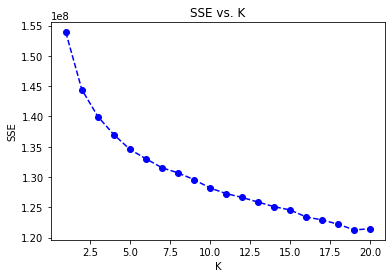

In [133]:

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [135]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200, n_features_in_int: 85)

KMeans(max_iter=100)

In [134]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=16)
kmeans.fit(azdias_scaled)
azdias_pred = kmeans.predict(azdias_scaled)

### Discussion 3.1: Apply Clustering to General Population

To determine which demographic clusters are particularly prevalent in the customer dataset, I first formed 20 clusters from the demographic dataset. I cleaned, scaled, and PCA-transformed the customer data. I used the k-means model to assign one of 16 labels to each data point in the customer dataset.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [136]:
customers=pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')


In [137]:
df_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [138]:
print(customers.head)

<bound method NDFrame.head of         AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0              2                     4          1            5.0   
1             -1                     4          1            NaN   
2             -1                     4          2            2.0   
3              1                     4          1            2.0   
4             -1                     3          1            6.0   
...          ...                   ...        ...            ...   
191647         1                     3          1            4.0   
191648        -1                     4          2            2.0   
191649         2                     4          1            2.0   
191650         3                     3          2            4.0   
191651         3                     2          1            2.0   

        FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                       5              1                 5               1 

In [139]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               191652 non-null  int64  
 1   ALTERSKATEGORIE_GROB   191652 non-null  int64  
 2   ANREDE_KZ              191652 non-null  int64  
 3   CJT_GESAMTTYP          188439 non-null  float64
 4   FINANZ_MINIMALIST      191652 non-null  int64  
 5   FINANZ_SPARER          191652 non-null  int64  
 6   FINANZ_VORSORGER       191652 non-null  int64  
 7   FINANZ_ANLEGER         191652 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  191652 non-null  int64  
 9   FINANZ_HAUSBAUER       191652 non-null  int64  
 10  FINANZTYP              191652 non-null  int64  
 11  GEBURTSJAHR            191652 non-null  int64  
 12  GFK_URLAUBERTYP        188439 non-null  float64
 13  GREEN_AVANTGARDE       191652 non-null  int64  
 14  HEALTH_TYP             191652 non-nu

In [140]:
def clean_data(customers,df_info,col_nan_cutoff=0.3,row_nan_cutoff=0.4):
    df_info['missing_or_unknown'] = df_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
    # A.2 Identify missing or unknown data values and convert them to NaNs.
    for att, missing_inds in zip(df_info['attribute'], df_info['missing_or_unknown']):
        if len(missing_inds)>0 and missing_inds != ['']:
            for ind in missing_inds:
                if ind.isnumeric() or ind.lstrip('-').isnumeric():
                    ind = int(ind)
                customers.loc[customers[att] == ind, att] = np.nan
    df1=customers.copy()
    print("{} rows and {} columns in the original dataset.".format(df1.shape[0],df1.shape[1]))
    # B. remove selected columns and rows, ...
    # B.1 How much missing data there is in each column of the dataset?
    col_nans = df1.isnull().sum()[df1.isnull().sum() > 0]
    col_nan_pct = col_nans/(df1.shape[0])
    # B.2 Save the missing data count, percentage and its corresponding column as dataframe
    col_nan_table = pd.DataFrame(data={'col_nan_ct': col_nans.values, 'col_nan_pct': col_nan_pct.values}, index=col_nans.index)
    col_nan_table.sort_values(by='col_nan_pct', ascending=False, inplace=True)
    # B.3 Get a list of the features we would like to remove
    outlier_col = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'] 
    # B.5 Remove the outlier columns where we see missing data percentage > col_nan_cutoff
    df1.drop(outlier_col, axis=1, inplace=True)
    df2=df1.copy()
    print("Outlier Columns: \n",outlier_col)
    print("{} rows and {} columns after removing outlier columns.".format(df2.shape[0],df2.shape[1]))
    # B.6 How much data is missing in each row of the dataset?
    row_nans_all = df2.isnull().sum(axis=1)
    row_nans = df2.isnull().sum(axis=1)[customers.isnull().sum(axis=1) > 0]
    # B.7 Compute percentage of rows with missing data, sort from high to low
    row_nan_pct_all = row_nans_all/(df2.shape[1])
    row_nan_pct = row_nans/(df2.shape[1])
    row_nan_pct.sort_values(ascending=False,inplace=True)
    # B.8 Add a new column to show percentage of missing row data for each row to the current dataset
    df2 = df2.assign(NAN_PCT=pd.Series(row_nan_pct_all.values))
    # B.5 Remove the outlier rows where we see number of missing values >= row_nan_cutoff
    df3 =df2[df2['NAN_PCT'] < row_nan_cutoff]
    print("{} rows and {} columns after removing outlier rows.".format(df3.shape[0],df3.shape[1]))
    
    # C. select, re-encode, and engineer column values.
    # C.1 Get a list of all the categorical variables
    df_info1 = df_info[~df_info.attribute.isin(outlier_col)]
    def return_var_list(type):
        var_list = df_info1[df_info1['type'] == type].attribute.tolist()
        return var_list
    all_categ_var=return_var_list('categorical')
    # C.2 Find binary and multi-level categoricals
    categ_binary_var=[]
    categ_multi_var=[]
    for var in all_categ_var:
        if df3[var].nunique() <= 2:
            categ_binary_var.append(var)
        else:
            categ_multi_var.append(var)
    # C.2.1 Examine the values for all binary categoricals
    #print('Binary categoricals\n')
    #for var in categ_binary_var:
        #print(var,'\n',df3[var].value_counts(),'\n')
    # C.3 Re-encode categorical variable(s) to be kept in the analysis.
    df3['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    df3['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df3['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    # C.3.1 Dropping multi-level features
    df3.drop(categ_multi_var, axis=1, inplace=True)
    df4=df3.copy()
    print("{} rows and {} columns after re-encoding categorical features.".format(df4.shape[0],df4.shape[1]))
    # C.4 Get a list of all mixed type variables
    all_mixed_var=return_var_list('mixed')
    # C.5 Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables
    # C.5.1 decade 
    decade_map = {0: [1, 2], # 40s
              1: [3, 4], # 50s
              2: [5, 6, 7], # 60s
              3: [8, 9], # 70s
              4: [10, 11, 12, 13], # 80s
              5:[14, 15]} # 90s
    def decade(v):
        try:
            for k, values in decade_map.items():
                if v in values:
                    return k
        # Consider NaN case
        except ValueError:
            return np.nan
    # C.5.2 movement 
    movement_map = {1: [1, 3, 5, 8, 10, 12, 14], # Mainstream
              0: [2, 4, 6, 7, 9, 11, 13, 15]} # Avantgarde
    def movement(v):
        try:
            for k, values in movement_map.items():
                if v in values:
                    return k
            else:
                return 0
        # Consider NaN case
        except ValueError:
            return np.nan
    # C.5.3 Generate the two new variables
    df4['PRAEGENDE_JUGENDJAHRE_DECADE'] = df4['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    df4['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df4['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    # C.6 Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # C.6.1 Wealth 
    def wealth(v):
        # Consider NaN case
        if pd.isnull(v):
            return np.nan
        else:
            # Return 1st digit
            return int(str(v)[0])
    # C.6.2 Life stage
    def lifestage(v):
        # Consider NaN case
        if pd.isnull(v):
            return np.nan
        else:
            # Return 2nd digit
            return int(str(v)[1])
    # C.6.3 Generate the two new variables
    df4['CAMEO_INTL_2015_WEALTH'] = df4['CAMEO_INTL_2015'].apply(wealth)
    df4['CAMEO_INTL_2015_LIFESTAGE'] = df4['CAMEO_INTL_2015'].apply(lifestage)
    # C.7 Remove CAMEO_INTL_2015, PRAEGENDE_JUGENDJAHRE and the rest of the mixed columns
    df4.drop(all_mixed_var, axis=1, inplace=True)
    df5=df4.copy()
    print("{} rows and {} columns after re-encoding mixed-type features.".format(df5.shape[0],df5.shape[1]))
    # D. Check if any other cleaning work needs to be done
    # D.1 Check if there is any extreme correlations between the features
    #def get_redundant_pairs(customers):
        #'''Get diagonal and lower triangular pairs of correlation matrix'''
        #pairs_to_drop = set()
        #cols = customers.columns
        #for i in range(0, customers.shape[1]):
            #for j in range(0, i+1):
                #pairs_to_drop.add((cols[i], cols[j]))
        #return pairs_to_drop
    #def get_top_abs_correlations(customers, n=5):
        #au_corr = customers.corr().abs().unstack()
        #labels_to_drop = get_redundant_pairs(customers)
        #au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
        #return au_corr[0:n]
    #get_top_abs_correlations(df4)
    # D.2 Remove one of the variables in the above pairs with correlation 1.
    # corr_drop_list=['']
    # df5 = df4.drop(corr_drop_list, axis=1)
    df5 = df4.copy()
    # D.3 Remove the column 'NAN_CT' that contains the number of missing values for each row that I added before to the dataset
    if 'NAN_PCT' in df5.columns:
        df6 = df5.drop(['NAN_PCT'], axis=1)
    else:
        df6 = df5.copy()      
    # D.4 Fill in the rest of NaNs
    for col in df6.columns:
        df6[col] = df6[col].interpolate(limit_direction='both')
    print("{} rows and {} columns after additional cleaning.".format(df6.shape[0],df6.shape[1]))

    # Return the cleaned dataframe.
    return df6

In [141]:
cleaned_customer=clean_data(customers, df_info)

191652 rows and 85 columns in the original dataset.
Outlier Columns: 
 ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
191652 rows and 79 columns after removing outlier columns.
141725 rows and 80 columns after removing outlier rows.
141725 rows and 67 columns after re-encoding categorical features.


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


141725 rows and 65 columns after re-encoding mixed-type features.
141725 rows and 64 columns after additional cleaning.


In [142]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,2.0,NaN,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,4.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,3.0,0.0,NaN,1.0,3.0,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,NaN,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1.0,NaN,5.0,1.0,5.0,1.0,3.0,2.0,2.0,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,6.0,2.0,6.0,7.0,5.0,3.0,4.0,1.0,3.0,3.0,2.0,4.0,1.0,3.0,0.0,NaN,1.0,3.0,11.0,3.0,0.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,NaN,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,4.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,1.0,0.0,NaN,2.0,3.0,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,NaN,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,6.0,NaN,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,1.0,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0,0.0,NaN,1.0,1.0,8.0,0.0,0.0,4.0,NaN,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,2.0,1960.0,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,8.0,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,4.0,1.0,0.0,NaN,2.0,1.0,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,NaN,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [143]:
customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,94914.000000,191412.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,98628.000000,188439.000000,191652.000000,142662.000000,140599.000000,140711.000000,141070.000000,141070.000000,188439.000000,188439.000000,142902.000000,143165.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,142662.000000,145056.000000,2312.000000,142662.000000,191652.000000,122905.000000,145056.000000,145056.000000,188684.000000,79715.000000,134715.000000,145056.000000,139275.000000,139542.000000,141725.000000,145001.000000,141725.000000,141725.000000,135672.000000,135672.000000,135672.000000,135672.000000,82117.000000,135670.000000,141693.000000,141693.000000,141693.000000,141725.000000,131588.000000,135672.000000,188439.000000,131588.000000,140371.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141153.000000,141176.000000,141153.000000
mean,1.665761,3.053461,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,4.137958,1949.773127,6.302268,0.367171,1.953323,24.368004,7.262026,5.683023,3.145828,6.687910,3.209251,1.037284,5.687074,3.716311,3.742137,4.414026,4.112788,3.883163,4.185279,5.366477,4.408021,3.682497,3.165879,4.674535,4.483835,4.187246,3.528254,2.919161,1.670347,0.009865,1.360294,1.483955,2.576806,13.397966,2.267828,0.020392,2.942481,3.421803,4.251204,8.646371,5.053218,0.067413,2.369942,3.129978,1993.056659,3.723133,2.207058,1.209004,0.309968,0.153385,1.724588,3.630456,4.301758,3.881702,4.784577,3.852524,2.423967,3.627425,2.764327,3.982582,667.231216,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.823844,5.119517,2.897515
std,0.636370,1.066370,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,1.503946,14.926854,2.877181,0.482035,0.773689,12.296675,4.056017,4.341034,1.771351,3.090573,1.436958,0.237129,3.350531,1.113933,1.718039,1.733128,2.070958,1.840131,2.367407,1.443103,1.720909,1.573090,1.316221,2.041059,1.631941,1.872047,1.493916,1.219224,1.165237,0.098833,0.978540,0.499744,1.168486,4.365868,1.390620,0.152234,1.533347,1.623890,1.889949,1.154001,14.419710,0.545576,2.434227,1.439740,3.080241,2.095540,1.383509,1.086202,0.765292,0.476992,1.412479,1.168422,2.114614,1.607621,1.961473,0.830285,1.008134,1.282444,1.266050,1.956060,340.481722,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.009424,2.159184,1.420665
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1900.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,

In [144]:
scaled_customer = StandardScaler().fit_transform(cleaned_customer)
scaled_customer = pd.DataFrame(scaled_customer, index=cleaned_customer.index, columns=cleaned_customer.columns)

In [145]:
customer_pca = pca.transform(scaled_customer)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- CAMEO_INTL_2015_LIFESTAGE
- OST_WEST_KZ
- PRAEGENDE_JUGENDJAHRE_DECADE
- PRAEGENDE_JUGENDJAHRE_MOVEMENT
Feature names seen at fit time, yet now missing:
- AVANTGARDE
- CAMEO_DEUG_2015_1
- CAMEO_DEUG_2015_2
- CAMEO_DEUG_2015_3
- CAMEO_DEUG_2015_4
- ...

  warnings.warn(message, FutureWarning)


ValueError: ignored

In [ ]:
customer_clusters = kmeans.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
propotion_general = []
proportion_customers = []

In [ ]:
x = [i+1 for i in range(15)]
for i in range(15):
    propotion_general.append((azdias_pred == i).sum()/len(azdias_pred))
    proportion_customers.append((customer_clusters == i).sum()/len(customer_clusters))

df_general = pd.DataFrame({'cluster' : x, 'propotion_general' : propotion_general, 'proportion_customers':proportion_customers})


In [ ]:
pos = list(range(0, 10)) 
width = 0.3 

fig, ax = plt.subplots(figsize=(15,5))

plt.bar(pos, propotion_general, width) 
plt.bar([p + width for p in pos], propotion_customers, width) 

ax.set_ylabel('Proportion of persons in each cluster')
ax.set_xlabel('Clusters')

ax.set_title('General population vs Customers')

plt.legend(['General population', 'Customers'], loc='upper left')
plt.grid()
plt.show()


In [ ]:
def plot_cluster_comparison(cluster_num):
    
    fig, ax = plt.subplots(6,2, figsize=(12,25))
    
    # Customers
    pca_cluster = customers_pca[np.where(customers_processed==cluster_num)]
    customers_data = scaler.inverse_transform(pca.inverse_transform(pca_cluster))
    features = pd.DataFrame(np.round(customers_data), columns = cleaned_customer.columns)
    
    sns.countplot(features['SEMIO_REL'], ax = ax[0,0])
    sns.countplot(features['LIFE_STAGE'], ax = ax[1,0])
    sns.countplot(features['MOVEMENT'], ax = ax[2,0])
    sns.countplot(features['ALTERSKATEGORIE_GROB'], ax = ax[3,0])
    sns.countplot(features['SEMIO_KRIT'], ax = ax[4,0])
    sns.countplot(features['SEMIO_RAT'], ax = ax[5,0])
    
    # General population
    pca_cluster_gd = pca_fit[np.where(predictions==cluster_num)]
    gd_data = scaler.inverse_transform(pca.inverse_transform(pca_cluster_gd))
    features = pd.DataFrame(np.round(gd_data), columns = azdias_scaled.columns)
    
    sns.countplot(features['SEMIO_REL'], ax = ax[0,1])
    sns.countplot(features['LIFE_STAGE'], ax = ax[1,1])
    sns.countplot(features['MOVEMENT'], ax = ax[2,1])
    sns.countplot(features['ALTERSKATEGORIE_GROB'], ax = ax[3,1])
    sns.countplot(features['SEMIO_KRIT'], ax = ax[4,1])
    sns.countplot(features['SEMIO_RAT'], ax = ax[5,1])
    
    plt.subplots_adjust(top=0.96)
    fig.suptitle('Customer data vs General Population', fontsize=16)
    plt.show();

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

plot_cluster_comparison(10)

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
plot_cluster_comparison(8)

### Discussion 3.3: Compare Customer Data to Demographics Data

When including the population count for all including those we dropped for analysis as they had missing data, the culsters: 8,2,4 were the most over represented in the customer data compared to the general population data (16.42%, 4.06%%, 3.51%. These percentages were higher for low-NaN data. Based on the full general population data, it seems that clusters 4, 5, 6, 9, 10 were closely represented in both general population and customer data (difference of < 4%).

The must under-represented compared to full population data were clusters: 3, 1, and 7 by a substantial 10.84%, 7.57%, and 6.74% respectively.

To see which features define each cluster the most, I took the inverse transformation of the PCA, which gives us back the original features but on a standard scale. This is much easier to interpret than the principal components themselves.

Over-Represented Cluster: #8
LP_STATUS_FEIN_10.0 is the highest impact feature in the 8th cluster. It represents the highest income housholds and highest social status.
'LP_STATUS_GROB_5.0 represents the same aspect but on a less refined scale
GREEN_AVANTGARDE is the feature with the third highest impact in the 8th cluster. It represents participation and interest in environmental issues during a person's youth.
the least impactful feature in the 8th cluster is HH_EINKOMMEN_SCORE, which corroberates our first point as it is correlated with low income, but high income and status is the biggest definer of our cluster.
Therefore, people with a high income and high social status who are also environmentally conscious are significantly over represented in the customer data in comparison to the general population. This is a good target audience for any marketing campaing.

Over-Represented Cluster: #2
Two of the features cluster two is characterized by are:

LP_STATUS_GROB_2.0: average income and social status
LP_STATUS_FEIN_4.0: villagers
While average earning villagers are over-represented in the customer data, they are more closely represented than the people in cluster #8 above. Nevertheless, it could still probably be worth to target these people in a campaign

Under-Represented Cluster: #3
LP_STATUS_FEIN_2.0 is the biggest factor in the third cluster, and that represents orientation-seeking low-income earners.
FINANZTYP_1 is the second most important factor, and it represents people who are not interested in finance.
SEMIO_RAT is a variable that portrays rationality (higher values means less rational).
This means that low income people who are both irrational and do not care for finance much are under-represented in the customer population (which makes sense since this is a financial services company).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.